In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

# Explore Data

In [2]:
train_df = pd.read_csv('./digit-recognizer/train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

In [4]:
print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [5]:
test_df = pd.read_csv('./digit-recognizer/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


## Display Images

In [6]:
random_seed = np.random.randint(n_train, size = 10)

grid = make_grid(torch.Tensor((train_df.iloc[random_seed, 1:].as_matrix()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=10)

/Users/egg/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


1, 4, 2, 2, 6, 3, 3, 8, 2, 4


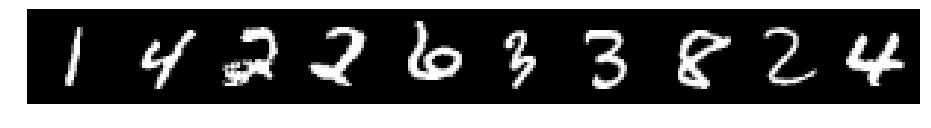

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_seed, 0].values), sep = ', ')

## Histogram of Classes

/Users/egg/anaconda3/envs/dl/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


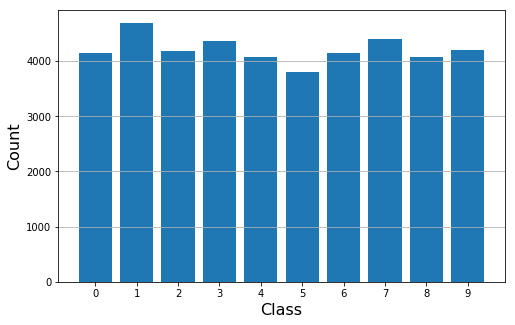

In [8]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

# Data Loader

In [9]:
class MNIST_data(Dataset) :
    def __init__(self, file_path, transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])) :
        df = pd.read_csv(file_path)
        if len(df.columns) == n_pixels :
            # Test Data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    def __len__(self) :
        return len(self.X)
    def __getitem__(self, idx) :
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

## Load Data

In [10]:
from torchvision.transforms import RandomRotation, RandomVerticalFlip

batch_size = 32
train_dataset = MNIST_data('./digit-recognizer/train.csv', \
                           transform= transforms.Compose([transforms.ToPILImage(),\
                                                         RandomRotation(degrees = 20),\
                                                         RandomVerticalFlip(p = 0.3),\
                                                         transforms.ToTensor(),\
                                                         transforms.Normalize(mean=(0.5,), std=(0.5,))]))

test_dataset = MNIST_data('./digit-recognizer/test.csv')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

In [19]:
# rotate = RandomRotation(20)
# shift = RandomVerticalFlip(p = 0.3)
# composed = transforms.Compose([rotate, shift])


# fig = plt.figure()
# sample = transforms.ToPILImage()(train_df.iloc[65,1:].reshape((28,28)).astype(np.uint8)[:,:,None])

# for i, tsfrm in enumerate([rotate, shift, composed]):
#     transformed_sample = tsfrm(sample)

#     ax = plt.subplot(1, 3, i + 1)
#     plt.tight_layout()
#     ax.set_title(type(tsfrm).__name__)
#     ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

# plt.show()

# Network

In [11]:
import math

class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, x) :
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x    

In [12]:
from torch.optim import lr_scheduler

model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/Users/egg/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Training and Evaluation

In [41]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        if (batch_idx + 1)% 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [42]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = data, target
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

# Training Network

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.379949

Average loss: 0.1057, Accuracy: 40585/42000 (96.000%)

Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.072677

Average loss: 0.0886, Accuracy: 40845/42000 (97.000%)

Train Epoch: 2 [32000/42000 (76%)]	Loss: 0.217940

Average loss: 0.0856, Accuracy: 40858/42000 (97.000%)

Train Epoch: 3 [32000/42000 (76%)]	Loss: 0.231699

Average loss: 0.0815, Accuracy: 40911/42000 (97.000%)

Train Epoch: 4 [32000/42000 (76%)]	Loss: 0.146071

Average loss: 0.0791, Accuracy: 40953/42000 (97.000%)

Train Epoch: 5 [32000/42000 (76%)]	Loss: 0.242875

Average loss: 0.0758, Accuracy: 41024/42000 (97.000%)

Train Epoch: 6 [32000/42000 (76%)]	Loss: 0.095676

Average loss: 0.0726, Accuracy: 41021/42000 (97.000%)

Train Epoch: 7 [32000/42000 (76%)]	Loss: 0.155796

Average loss: 0.0726, Accuracy: 41014/42000 (97.000%)

Train Epoch: 8 [32000/42000 (76%)]	Loss: 0.140335

Average loss: 0.0711, Accuracy: 41052/42000 (97.000%)

Train Epoch: 9 [32000/42000 (76%)]	Loss: 0.065